In [1]:
!pip install transformers

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [3]:
!pip install sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 29.5 MB/s eta 0:00:00


In [4]:
from datasets import load_dataset
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
    get_scheduler,
    AutoModelForMultipleChoice,
    AutoConfig,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments
)
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from tqdm import tqdm
import seaborn as sns


import openai

import random
import re

import os
import google.generativeai as genai



In [5]:

# Load the MedQA dataset (US version)
dataset = load_dataset("VodLM/medqa", "us")

# Check available splits
print(dataset)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

medqa.py:   0%|          | 0.00/5.45k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/7.69M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/964k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/997k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10178 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1272 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1273 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['idx', 'uid', 'question', 'metamap', 'target', 'answers'],
        num_rows: 10178
    })
    validation: Dataset({
        features: ['idx', 'uid', 'question', 'metamap', 'target', 'answers'],
        num_rows: 1272
    })
    test: Dataset({
        features: ['idx', 'uid', 'question', 'metamap', 'target', 'answers'],
        num_rows: 1273
    })
})


In [6]:

# Convert dataset to pandas DataFrame
train_data = dataset["train"].to_pandas()
test_data = dataset["test"].to_pandas()
validation_data = dataset["validation"].to_pandas()




In [7]:
train_data.head()

,idx,uid,question,metamap,target,answers
0,0,train-0,A 23-year-old pregnant woman at 22 weeks gesta...,23 year old pregnant woman weeks presents burn...,3,"[Ampicillin, Ceftriaxone, Doxycycline, Nitrofu..."
1,1,train-1,A 3-month-old baby died suddenly at night whil...,3 month old baby died night asleep mother died...,0,[Placing the infant in a supine position on a ...
2,2,train-2,A mother brings her 3-week-old infant to the p...,mother week old infant pediatrician's office c...,0,"[Abnormal migration of ventral pancreatic bud,..."
3,3,train-3,A pulmonary autopsy specimen from a 58-year-ol...,pulmonary autopsy specimen 58 year old woman d...,0,"[Thromboembolism, Pulmonary ischemia, Pulmonar..."
4,4,train-4,A 20-year-old woman presents with menorrhagia ...,20 year old woman presents menorrhagia past ye...,3,"[Hemophilia A, Lupus anticoagulant, Protein C ..."


# **BIOGPT - ZERO SHOT PROMPTING**

vocab.json:   0%|          | 0.00/927k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/696k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.47k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/691 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/412 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


✅ Zero-Shot BioGPT Accuracy: 0.2704
🎯 Total Correct Predictions: 344 out of 1272

              precision    recall  f1-score   support

           A       0.28      0.27      0.27       330
           B       0.28      0.28      0.28       316
           C       0.29      0.27      0.28       352
           D       0.23      0.27      0.24       274

    accuracy                           0.27      1272
   macro avg       0.27      0.27      0.27      1272
weighted avg       0.27      0.27      0.27      1272



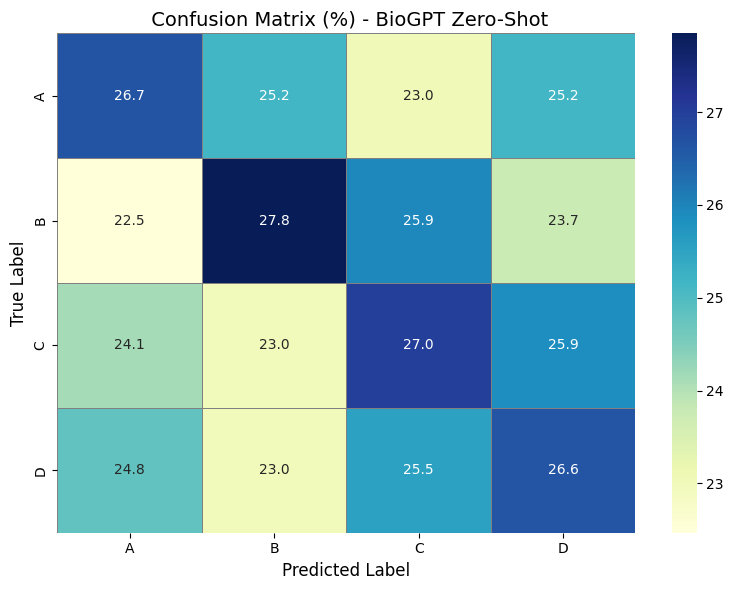

In [9]:

model_name = "microsoft/BioGPT"
model = AutoModelForCausalLM.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "left"

# Freeze model (no training)
for param in model.parameters():
    param.requires_grad = False

# ------------------ Sentence encoder for similarity matching ------------------
encoder = SentenceTransformer("pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb")

LETTER_MAP = ["A", "B", "C", "D"]

# ------------------ Prompt Format ------------------
def build_zero_shot_prompt(example):
    answers = example['answers'].tolist() if hasattr(example['answers'], 'tolist') else example['answers']
    return (
        "You are a helpful biomedical assistant. Read the following multiple-choice question carefully and select the correct answer based only on the information provided.\n\n"
        f"Question: {example['question']}\n"
        f"Options:\n"
        f"A: {answers[0]}\n"
        f"B: {answers[1]}\n"
        f"C: {answers[2]}\n"
        f"D: {answers[3]}\n"
        "Answer (only generate a single letter from A, B, C, D corresponding to the correct answer):"
    )

# ------------------ Zero-Shot Evaluation ------------------
def evaluate_biogpt_zeroshot(model, tokenizer, encoder, val_data, max_length=512):
    predictions = []
    gold_labels = []

    for example in tqdm(val_data, desc="Zero-shot BioBGPT Evaluation", dynamic_ncols=True, leave=False):
        prompt = build_zero_shot_prompt(example)

        inputs = tokenizer(prompt, return_tensors="pt", padding="max_length", truncation=True, max_length=max_length).to(model.device)

        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=64)

        decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Extract generated answer
        generated_answer = decoded.split("Answer:")[-1].strip().lower()

        # Match generated text to closest option
        options = example['answers'].tolist() if hasattr(example['answers'], 'tolist') else example['answers']
        answer_embedding = encoder.encode(generated_answer, convert_to_tensor=True)
        option_embeddings = encoder.encode([a.lower() for a in options], convert_to_tensor=True)
        sim = util.cos_sim(answer_embedding, option_embeddings)
        pred_idx = torch.argmax(sim).item()

        predictions.append(LETTER_MAP[pred_idx])
        gold_labels.append(LETTER_MAP[example['target']])

    return predictions, gold_labels

# ------------------ Run Evaluation ------------------
val_records = validation_data.to_dict(orient="records")

predictions, gold_labels = evaluate_biogpt_zeroshot(model, tokenizer, encoder, val_records)

# ------------------ Metrics ------------------
# Accuracy
accuracy = accuracy_score(gold_labels, predictions)
total_correct = sum(p == g for p, g in zip(predictions, gold_labels))
total_samples = len(gold_labels)

# Print Results
print(f"\n✅ Zero-Shot BioGPT Accuracy: {accuracy:.4f}")
print(f"🎯 Total Correct Predictions: {total_correct} out of {total_samples}\n")

# Classification Report
print(classification_report(gold_labels, predictions, labels=LETTER_MAP))

# ------------------ Confusion Matrix ------------------
# Compute confusion matrix
cm = confusion_matrix(gold_labels, predictions, labels=LETTER_MAP)

# Normalize
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Convert to DataFrame
cm_df = pd.DataFrame(cm_normalized, index=LETTER_MAP, columns=LETTER_MAP)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=0.5, linecolor='gray')
plt.title(" Confusion Matrix (%) - BioGPT Zero-Shot", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()


# **BIOBART - ZERO SHOT PROMPTING**


✅ Zero-Shot BioBART Accuracy: 0.2634
🎯 Total Correct Predictions: 335 out of 1272

              precision    recall  f1-score   support

           A       0.27      0.40      0.33       330
           B       0.27      0.26      0.26       316
           C       0.30      0.18      0.23       352
           D       0.21      0.21      0.21       274

    accuracy                           0.26      1272
   macro avg       0.26      0.26      0.26      1272
weighted avg       0.27      0.26      0.26      1272



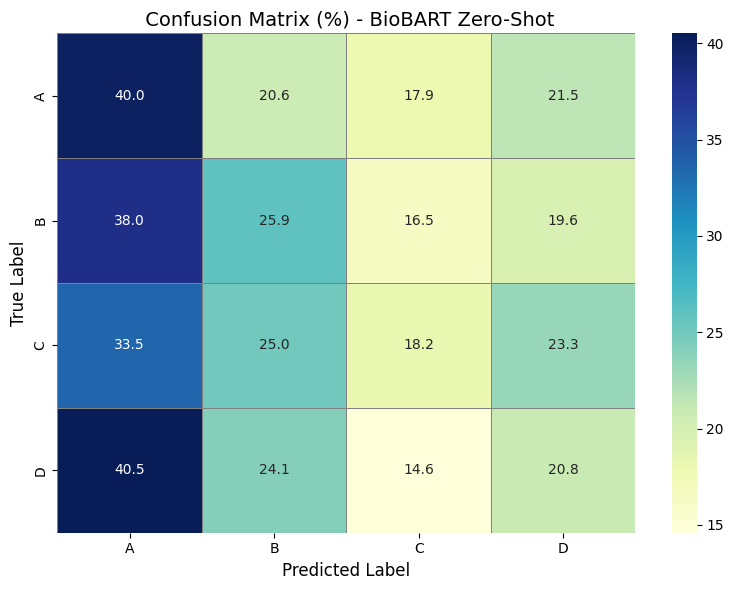

In [ ]:

# ------------------ Load BioBART Model ------------------
model = AutoModelForSeq2SeqLM.from_pretrained('GanjinZero/biobart-v2-base').to("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained('GanjinZero/biobart-v2-base')
tokenizer.padding_side = "left"

# Freeze model (no training)
for param in model.parameters():
    param.requires_grad = False

# ------------------ Sentence encoder for similarity matching ------------------
encoder = SentenceTransformer("pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb")

LETTER_MAP = ["A", "B", "C", "D"]

# ------------------ Prompt Format ------------------
def build_zero_shot_prompt(example):
    answers = example['answers'].tolist() if hasattr(example['answers'], 'tolist') else example['answers']
    return (
        "You are a helpful biomedical assistant. Read the following multiple-choice question carefully and select the correct answer based only on the information provided.\n\n"
        f"Question: {example['question']}\n"
        f"Options:\n"
        f"A: {answers[0]}\n"
        f"B: {answers[1]}\n"
        f"C: {answers[2]}\n"
        f"D: {answers[3]}\n"
        "Answer (only generate a single letter from A, B, C, D corresponding to the correct answer):"
    )

# ------------------ Zero-Shot Evaluation ------------------
def evaluate_biobart_zeroshot(model, tokenizer, encoder, val_data, max_length=512):
    predictions = []
    gold_labels = []

    for example in tqdm(val_data, desc="Zero-shot BioBART Evaluation", dynamic_ncols=True, leave=False):
        prompt = build_zero_shot_prompt(example)

        inputs = tokenizer(prompt, return_tensors="pt", padding="max_length", truncation=True, max_length=max_length).to(model.device)

        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=64)

        decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Extract generated answer
        generated_answer = decoded.split("Answer:")[-1].strip().lower()

        # Match generated text to closest option
        options = example['answers'].tolist() if hasattr(example['answers'], 'tolist') else example['answers']
        answer_embedding = encoder.encode(generated_answer, convert_to_tensor=True)
        option_embeddings = encoder.encode([a.lower() for a in options], convert_to_tensor=True)
        sim = util.cos_sim(answer_embedding, option_embeddings)
        pred_idx = torch.argmax(sim).item()

        predictions.append(LETTER_MAP[pred_idx])
        gold_labels.append(LETTER_MAP[example['target']])

    return predictions, gold_labels

# ------------------ Run Evaluation ------------------
val_records = validation_data.to_dict(orient="records")

predictions, gold_labels = evaluate_biobart_zeroshot(model, tokenizer, encoder, val_records)

# ------------------ Metrics ------------------
# Accuracy
accuracy = accuracy_score(gold_labels, predictions)
total_correct = sum(p == g for p, g in zip(predictions, gold_labels))
total_samples = len(gold_labels)

# Print Results
print(f"\n✅ Zero-Shot BioBART Accuracy: {accuracy:.4f}")
print(f"🎯 Total Correct Predictions: {total_correct} out of {total_samples}\n")

# Classification Report
print(classification_report(gold_labels, predictions, labels=LETTER_MAP))

# ------------------ Confusion Matrix ------------------
# Compute confusion matrix
cm = confusion_matrix(gold_labels, predictions, labels=LETTER_MAP)

# Normalize
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Convert to DataFrame
cm_df = pd.DataFrame(cm_normalized, index=LETTER_MAP, columns=LETTER_MAP)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=0.5, linecolor='gray')
plt.title(" Confusion Matrix (%) - BioBART Zero-Shot", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()
